# Problem - 1

Train a DC GAN (with an architecture of your choice) on the given data
with the usual GAN loss. Plot the loss curves for the Generator and
Discriminator losses.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)



In [2]:
data_dir = "Animals_data/animals/animals"  
# data_dir = "butterfly_images"

ngpu = 1 #number of gpu available
img_size = 128

batch_size = 128

z=100 #latent space size

workers = 8 #number of workers for dataloader

gf = 64 #generator filter size
df = 64 #discriminator filter size

lr = 0.0002 #learning rate
beta1 = 0.5 #beta1 for adam
epochs = 5 #number of epochs to train for



20
Time taken to initialize dataset: 0.004294872283935547 seconds
Creating train dataloader...
Time taken to create DataLoader: 0 hr:00 min:00 sec
Train data samples:  1200
Training samples for class eagle: 60
Training samples for class turtle: 60
Training samples for class pigeon: 60
Training samples for class sparrow: 60
Training samples for class deer: 60
Training samples for class elephant: 60
Training samples for class hippopotamus: 60
Training samples for class dragonfly: 60
Training samples for class mosquito: 60
Training samples for class butterfly: 60
Training samples for class snake: 60
Training samples for class horse: 60
Training samples for class bison: 60
Training samples for class parrot: 60
Training samples for class orangutan: 60
Training samples for class possum: 60
Training samples for class flamingo: 60
Training samples for class sandpiper: 60
Training samples for class rat: 60
Training samples for class coyote: 60


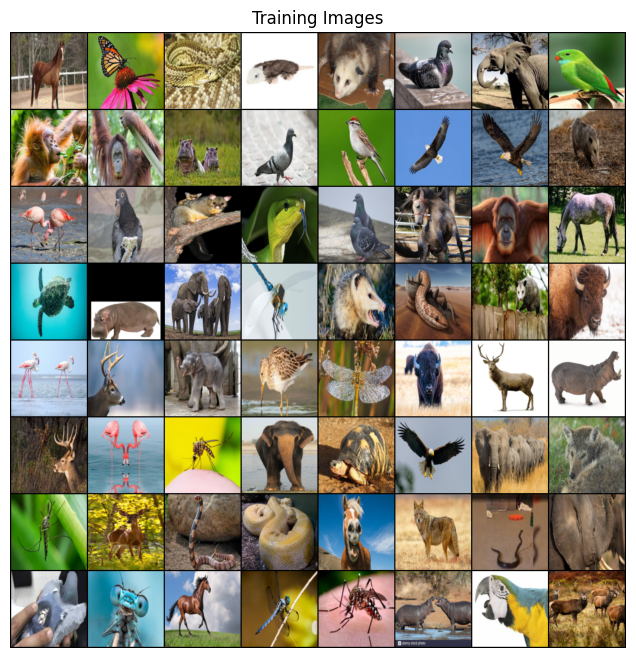

In [3]:
import torch.utils.data.dataloader as DataLoader
import time
from torchvision import transforms
from PIL import Image
import os
 
def seconds_to_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return "%d hr:%02d min:%02d sec" % (h, m, s)
 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(3)], [0.5 for _ in range(3)]
    ),
])
import time
 
class AnimalsDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None, target_transform=None, train=True):
        start_time = time.time()
        super(AnimalsDataset, self).__init__(root, transform=transform, target_transform=target_transform)
        self.train = train
        self.data = []
        self.targets = []
        # self.classes = ['antelope', 'badger', 'bat', 'bear', 'bee',
        # 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar',
        # 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow',
        # 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle',
        # 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose',
        # 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus',
        # 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo',
        # 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito',
        # 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox',
        # 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon',
        # 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros',
        # 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow',
        # 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle',
        # 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']
        
        self.classes = ['eagle', 'turtle', 'pigeon', 'sparrow', 'deer', 'elephant', 'hippopotamus', 'dragonfly', 'mosquito', 'butterfly', 'snake', 'horse', 'bison', 'parrot', 'orangutan', 'possum', 'flamingo', 'sandpiper', 'rat', 'coyote']
        
        
        self.class_to_idx = {}
        self.idx_to_class = {}
        self.transform = transform
        self.target_transform = target_transform
        self.class_counts = {class_name: 0 for class_name in self.classes}
        
        print(len(self.classes))
        for i, d in enumerate(self.classes):
            self.class_to_idx[d] = i
            self.idx_to_class[i] = d
            for img in os.listdir(os.path.join(root, d)):
                self.data.append(os.path.join(root, d, img))
                self.targets.append(i)
                self.class_counts[d] += 1
 
        end_time = time.time()
        print(f"Time taken to initialize dataset: {end_time - start_time} seconds")
 
    def __getitem__(self, index):
        img_path, target = self.data[index], self.targets[index]
        img = Image.open(img_path).convert('RGB')
 
        if self.transform is not None:
            img = self.transform(img)
 
        return img, target
 
    def __len__(self):
        return len(self.data)
 
    def get_class_counts(self):
        return self.class_counts
 

train_dataset = AnimalsDataset(root=data_dir, transform=transform, train=True)
 
start_time = time.time()
 
print("Creating train dataloader...")
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
end_time = time.time()
 
print(f'Time taken to create DataLoader: {seconds_to_hms(end_time - start_time)}')
print(f'Train data samples: ', len(train_dataset))
 
train_class_counts = train_dataset.get_class_counts()
for class_name, count in train_class_counts.items():
    print(f"Training samples for class {class_name}: {count}")
 
# Profile the data loading process
# start_time = time.time()
# for i, data in enumerate(dataloader):
#     if i == 10:  # Profile the first 10 batches
#         break
# end_time = time.time()
# print(f'Time taken to load 10 batches: {seconds_to_hms(end_time - start_time)}')
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:

# dataset  =  datasets.ImageFolder(root=data_dir, transform=transforms.Compose([
#     transforms.Resize(img_size),
#     transforms.CenterCrop(img_size),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ]))

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# # plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weights Initialization (According to DCGAN paper)

In [5]:
# weights initialization for the generator and discriminator
# In DC-GAN, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. Using the same 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
        

## Generator Model

In [6]:
# device = torch.device( "cpu")

In [7]:
# Generator
class conditionalGenerator(nn.Module):
    def __init__(self,num_classes=20,embed_size=100,z=100): 
        super(conditionalGenerator, self).__init__()  
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z+embed_size, out_channels=gf*16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(gf*16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf*16, out_channels=gf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf*8, out_channels=gf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf*4, out_channels=gf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf*2, out_channels=gf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)
        # print(self.embed)
    def forward(self, input,labels):
        
        # print(max(labels),min(labels))
        
        embedd = self.embed(labels).unsqueeze(2).unsqueeze(3)
        
        # print(embedd.shape,input.shape)
        input = torch.cat([input,embedd],1)
        # print(input.shape)
        return self.gen(input)
    
print(conditionalGenerator())
            

conditionalGenerator(
  (gen): Sequential(
    (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1

In [8]:
Gen_model = conditionalGenerator(num_classes=20,embed_size=100,z=100).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    
    Gen_model = nn.DataParallel(Gen_model, device_ids=[0, 1,2])
    
Gen_model.apply(weights_init) # apply the weights_init function


conditionalGenerator(
  (gen): Sequential(
    (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1

## Discriminator Model 

In [9]:
class conditionalDiscriminator(nn.Module):
    def __init__(self,num_classes=20,img_size=128):
        super(conditionalDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels=3+1, out_channels=df, kernel_size=4, stride=2, padding=1, bias=False), #1 for the label embedding
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df, out_channels=df*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df*2, out_channels=df*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df*4, out_channels=df*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df*8, out_channels=df*16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df*16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df*16, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            
        )
        
        self.embed = nn.Embedding(num_classes, img_size*img_size)
    def forward(self, input, labels):
        embed = self.embed(labels).view(labels.size(0),1,img_size,img_size)
        input = torch.cat([input,embed],1)
        # input = input + noise_variance*torch.randn_like(input)
        return self.disc(input)
    
print(conditionalDiscriminator())

conditionalDiscriminator(
  (disc): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024

In [10]:
Disc_model = conditionalDiscriminator().to(device)
if (device.type == 'cuda') and (ngpu > 1):
    Disc_model = nn.DataParallel(Disc_model, device_ids=[0, 1,2])
    
Disc_model.apply(weights_init) # apply the weights_init function


conditionalDiscriminator(
  (disc): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024

In [11]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(128, z, 1, 1, device=device)

real_label = 1
fake_label = 0

disc_lr = 0.0002
gen_lr = 0.0002

optimizerD = optim.Adam(Disc_model.parameters(), lr=disc_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(Gen_model.parameters(), lr=gen_lr, betas=(beta1, 0.999))

# optimizerD = optim.Adam(Disc_model.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(Gen_model.parameters(), lr=lr, betas=(beta1, 0.999))



## Training

In [12]:
img_list = []
gen_losses = [] 
disc_losses = []
label_smoothing = False
noise_variance = 0
gen_updates = 1
disc_updates = 1

In [13]:
iters = 0
num_epochs = 300
print("Starting Training Loop...")

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(device)
for epoch in range(num_epochs):
    for i,data in enumerate(dataloader, 0):
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)   
        # update Disc model : maximize log(D(x)) + log(1 - D(G(z)))
        Disc_model.zero_grad()
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
                
        output = Disc_model(real_cpu,data[1].to(device)).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, z, 1, 1, device=device)
        fake = Gen_model(noise, data[1].to(device)) #data[1] is the label
        label.fill_(fake_label)
        output = Disc_model(fake.detach(),  data[1].to(device)).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        disc_losses.append(errD.item())
        
    
            
        # update Gen model : maximize log(D(G(z)))
        Gen_model.zero_grad()
        label.fill_(real_label)
        output = Disc_model(fake, data[1].to(device)).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        gen_losses.append(errG.item())
            
    
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        num_classes = 20
        if (iters)%500 == 0 or (i == len(dataloader)-1) or (epoch == num_epochs-1):
            
            
            with torch.no_grad():
                fake_labels = torch.randint(0,num_classes,(fixed_noise.size(0),),device=device)
                fake = Gen_model(fixed_noise,fake_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            plt.imsave(f"conditional_animal_images_20classes/{epoch}_{iters}.png", img_list[-1].numpy().transpose((1,2,0)))
            
        iters += 1
        
    if epoch%25 == 0:
        torch.save(Gen_model.state_dict(), f"conditional_models_20classes/gen_{epoch}.pth")
        torch.save(Disc_model.state_dict(), f"conditional_models_20classes/disc_{epoch}.pth")
        
        
       
            
            

Starting Training Loop...
cuda:3


[0/300][0/10]	Loss_D: 1.8824	Loss_G: 13.7662	D(x): 0.5570	D(G(z)): 0.5414 / 0.2217
[1/300][0/10]	Loss_D: 0.7453	Loss_G: 9.2919	D(x): 0.7434	D(G(z)): 0.0034 / 0.0195
[2/300][0/10]	Loss_D: 3.0577	Loss_G: 30.3570	D(x): 0.9355	D(G(z)): 0.5998 / 0.0000
[3/300][0/10]	Loss_D: 0.7138	Loss_G: 11.9287	D(x): 0.8765	D(G(z)): 0.1814 / 0.0015
[4/300][0/10]	Loss_D: 0.5780	Loss_G: 6.7683	D(x): 0.8129	D(G(z)): 0.1109 / 0.0038
[5/300][0/10]	Loss_D: 0.4310	Loss_G: 6.8163	D(x): 0.7775	D(G(z)): 0.0254 / 0.0187
[6/300][0/10]	Loss_D: 0.6741	Loss_G: 11.4741	D(x): 0.9151	D(G(z)): 0.2527 / 0.0086
[7/300][0/10]	Loss_D: 8.4497	Loss_G: 11.7865	D(x): 0.4354	D(G(z)): 0.5264 / 0.0030
[8/300][0/10]	Loss_D: 2.1361	Loss_G: 7.0472	D(x): 0.7523	D(G(z)): 0.5848 / 0.0101
[9/300][0/10]	Loss_D: 0.5785	Loss_G: 3.5645	D(x): 0.7898	D(G(z)): 0.1691 / 0.0509
[10/300][0/10]	Loss_D: 0.6073	Loss_G: 5.9841	D(x): 0.7790	D(G(z)): 0.1497 / 0.0146
[11/300][0/10]	Loss_D: 1.0515	Loss_G: 7.4202	D(x): 0.8001	D(G(z)): 0.4078 / 0.0389
[12/300][

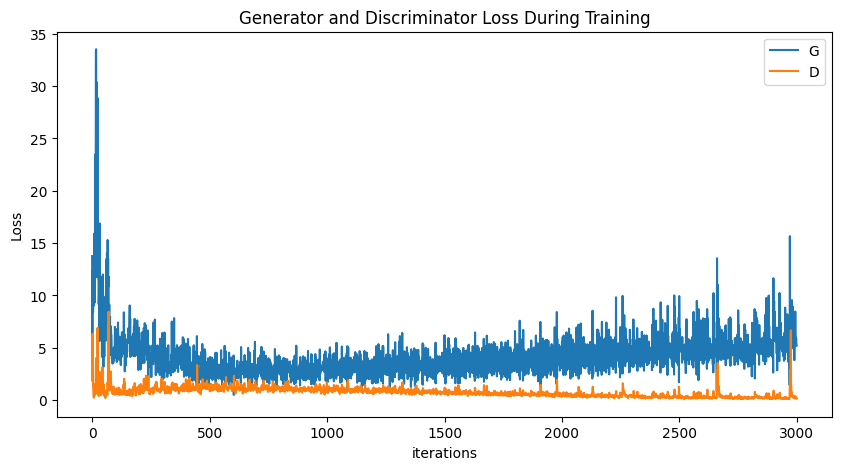

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [20]:
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())


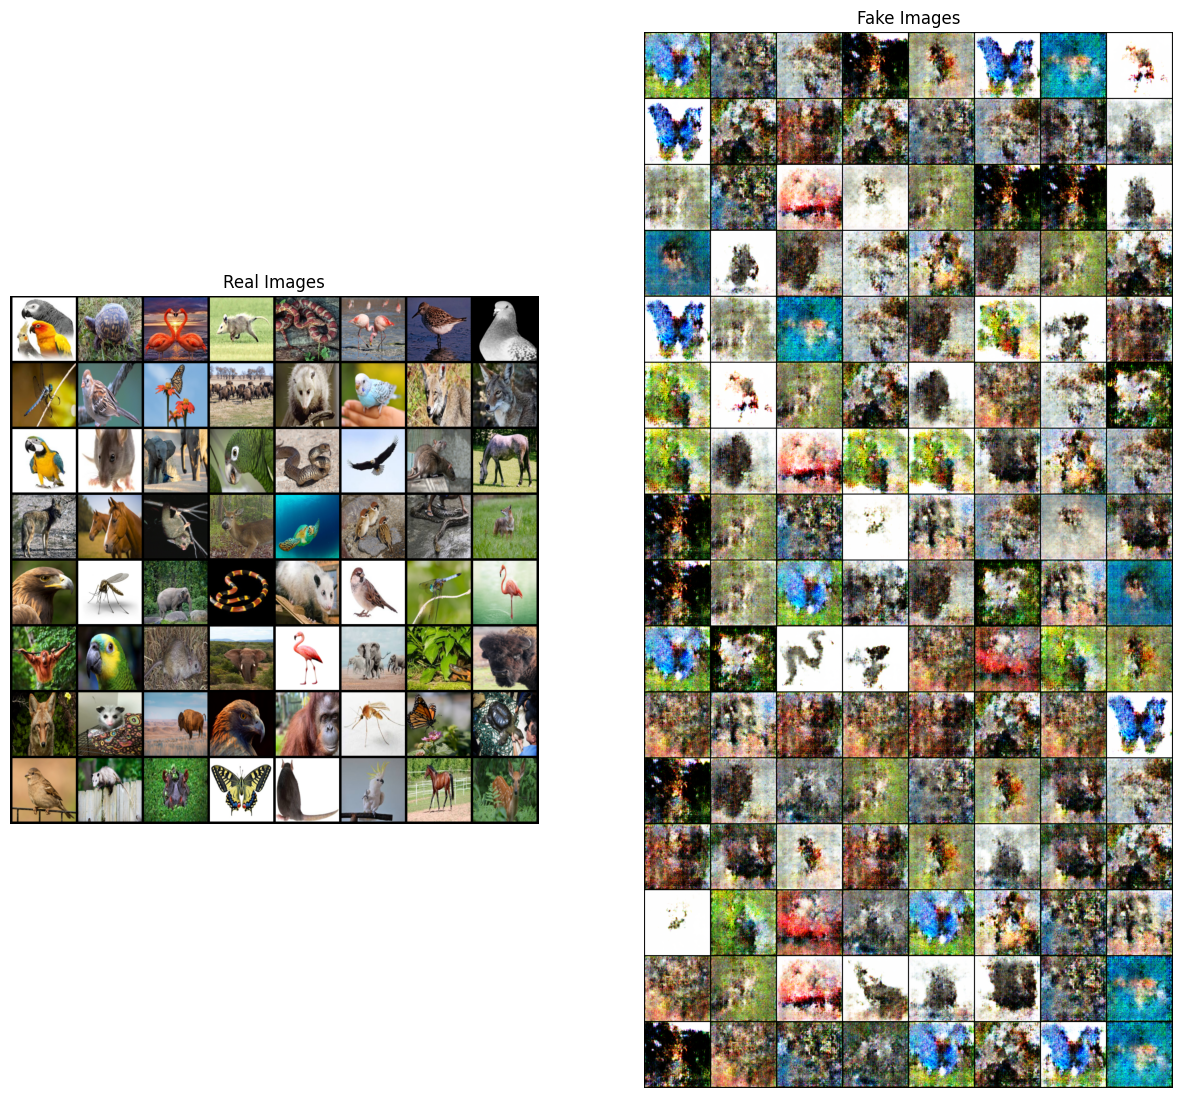

In [16]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
from torchvision.utils import make_grid, save_image
import torch_fidelity
torch_fidelity.defaults.DEFAULTS['samples_find_deep'] = True
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
netG = conditionalGenerator(num_classes=20,embed_size=100,z=100).to(device)

num_images = 1000
batch_size = 100
num_batches = num_images//batch_size
fids = {}

for epoch in range(0,300,25):
    print(epoch)
    netG.load_state_dict(torch.load(f'conditional_models_20classes/gen_{epoch}.pth'))
    for i in range(num_batches):
        noise = torch.randn(batch_size, z, 1, 1, device=device)
        labels = torch.randint(0,20,(batch_size,),device=device)
        gen_samples = netG(noise, labels).detach().cpu()
        for id, sample in enumerate(gen_samples):
            sample = sample.view(3,
                                128,
                                128)
            sample = (sample/2.0 + 0.5).clip(0,1)

            save_image(sample, os.path.join('cond_gen20', 'sample_{}.jpg'.format(i*batch_size + id)))

    metrics_dict = torch_fidelity.calculate_metrics(
    input1='cond_gen20', 
    input2='compare_animals', 
    cuda=True, 
    isc=True, 
    fid=True, 
    kid=True, 
    prc=True, 
    verbose=False,
    )
    fids[epoch] = metrics_dict['frechet_inception_distance']


0


/tmp/ipykernel_2733007/1671458187.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(f'conditional_models_20classes/gen_{epoch}.pth'))


In [ ]:
plt.plot(list(fids.keys()),list(fids.values()),'-o')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('Epoch vs FID')
plt.show()

In [ ]:
# import torch_fidelity
# torch_fidelity.defaults.DEFAULTS['samples_find_deep'] = True
# metrics_dict = torch_fidelity.calculate_metrics(
#     input1='gen', 
#     input2='butterfly_images/test', 
#     cuda=True, 
#     isc=True, 
#     fid=True, 
#     kid=True, 
#     prc=True, 
#     verbose=False,
# )

# print(metrics_dict)

In [ ]:
print("FID: ", metrics_dict['frechet_inception_distance'])

In [ ]:
# import os
# import random
# import shutil
# from PIL import Image

# # Define the source and destination directories
# source_dir = 'Animals_data/animals'
# destination_dir = 'compare_animals'
# target_size = (128, 128)  # Define the target size for resizing

# # Ensure the destination directory exists
# os.makedirs(destination_dir, exist_ok=True)

# # Collect all image paths from the source directory
# image_paths = []
# for root, _, files in os.walk(source_dir):
#     for file in files:
#         if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#             image_paths.append(os.path.join(root, file))

# # Randomly sample 1000 images
# sampled_images = random.sample(image_paths, 1000)

# # Resize and copy the sampled images to the destination directory
# for image_path in sampled_images:
#     with Image.open(image_path) as img:
#         img_resized = img.resize(target_size)
#         img_resized.save(os.path.join(destination_dir, os.path.basename(image_path)))

# print(f'Successfully copied and resized {len(sampled_images)} images to {destination_dir}')

In [ ]:
# # Ensure you import your Generator model

# # Define the device and load the generator model
# device = 'cuda:0'
# netG = Generator().to(device)
# # netG.load_state_dict(torch.load('models/gen_final.pth'))  # Load your trained generator model

# netG.load_state_dict(torch.load(f'models/gen_275.pth'))
# netG.eval()

# # Define the latent vector size
# z_dim = 100

# # Function to generate images from latent vectors
# def generate_images(latent_vectors):
#     with torch.no_grad():
#         images = netG(latent_vectors).cpu()
#     return images

# # Function to perform linear interpolation
# def linear_interpolation(z1, z2, steps=10):
#     return [(1 - alpha) * z1 + alpha * z2 for alpha in np.linspace(0, 1, steps)]

# # Function to perform spherical interpolation (non-linear)
# def spherical_interpolation(z1, z2, steps=10):
#     omega = np.arccos(np.dot(z1 / np.linalg.norm(z1), z2 / np.linalg.norm(z2)))
#     return [torch.tensor(np.sin((1 - alpha) * omega) / np.sin(omega) * z1 + np.sin(alpha * omega) / np.sin(omega) * z2) for alpha in np.linspace(0, 1, steps)]

# # Sample two random latent vectors
# z1 = torch.randn(1, z_dim, 1, 1, device=device)
# z2 = torch.randn(1, z_dim, 1, 1, device=device)

# # Perform linear interpolation
# linear_latents = torch.stack(linear_interpolation(z1, z2)).view(-1, z_dim, 1, 1)

# # Perform spherical interpolation
# spherical_latents = torch.stack(spherical_interpolation(z1.squeeze().cpu().numpy(), z2.squeeze().cpu().numpy())).view(-1, z_dim, 1, 1).to(device)

# # Generate images from interpolated latent vectors
# linear_images = generate_images(linear_latents)
# spherical_images = generate_images(spherical_latents)

# # print(linear_latents.shape)
# # print(linear_images.shape)
# # print(spherical_images.shape)
# # Plot the images
# def plot_images(images, title):
#     grid = make_grid(images, nrow=10, normalize=True, scale_each=True)
#     plt.figure(figsize=(15, 15))
#     plt.imshow(grid.permute(1, 2, 0).numpy())
#     plt.title(title)
#     plt.axis('off')
#     plt.show()

# plot_images(linear_images, 'Linear Interpolation')
# plot_images(spherical_images, 'Spherical Interpolation')


In [4]:
''' sample 20 classes from these self.classes = ['antelope', 'badger', 'bat', 'bear', 'bee',
        'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar',
        'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow',
        'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle',
        'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose',
        'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus',
        'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo',
        'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito',
        'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox',
        'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon',
        'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros',
        'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow',
        'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle',
        'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']'''
        
# Sample 20 classes
classes = ['antelope', 'badger', 'bat', 'bear', 'bee',
        'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar',
        'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow',
        'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle',
        'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose',
        'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus',
        'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo',
        'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito',
        'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox',
        'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon',
        'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros',
        'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow',
        'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle',
        'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


# write random code to pick  20 classes
import random
import os
import shutil

# write random code to pick  20 classes
 
classes = random.sample(classes, 20)
print(classes)

['eagle', 'turtle', 'pigeon', 'sparrow', 'deer', 'elephant', 'hippopotamus', 'dragonfly', 'mosquito', 'butterfly', 'snake', 'horse', 'bison', 'parrot', 'orangutan', 'possum', 'flamingo', 'sandpiper', 'rat', 'coyote']


In [ ]:
# consider  images from these 20 classes and store  ['eagle', 'turtle', 'pigeon', 'sparrow', 'deer', 'elephant', 'hippopotamus', 'dragonfly', 'mosquito', 'butterfly', 'snake', 'horse', 'bison', 'parrot', 'orangutan', 'possum', 'flamingo', 'sandpiper', 'rat', 'coyote'] which are in Animals_data/animals/animals

